In [1]:
from navground import sim,core
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial.distance as dist
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr, shapiro, skew, iqr

import matplotlib.colors as colors
import matplotlib.cm as cmx
from navground.sim.ui.video import display_video, display_video_from_run

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("../../..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

2024-08-29 15:59:06.987991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 15:59:06.998923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 15:59:07.002232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 15:59:07.011925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 15:59:14.341510: W tensorflow/compiler/tf2

The collisions are given in an array with number of rows equal to the number of collisions in the whole simulation, i.e. if there are 50 collisions during a simulation, it will have 50 rows. The first column indicates the time instant in which the collision occurs and the other 2 columns specify the id of the robots that collide at that instant.

In [3]:
time_instances=1000
time_step=0.1
simulations = 100
sideLength = 4
behavior="ORCA"
#any missing space in the yaml or misspelling is an error.
yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
record_efficacy: true
run_index: 0
scenario:
  type: Cross
  agent_margin: 0.1
  side: {sideLength}
  target_margin: 0.5
  tolerance: 0.25
  groups:
    -
      type: thymio
      number: 40
      radius: 0.08
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: 0.166
      behavior:
        type: {behavior}
        optimal_speed: 0.12
        horizon: 5.0
        safety_margin:
          sampler: uniform
          from: 0.0
          to: 0.2
          once: true
      state_estimation:
        type: Bounded
        range: 5
"""

experimentORCA = sim.load_experiment(yaml)
experimentORCA.run(number_of_threads = 12) # con 0 hilos 10 segundos 10 simulaciones, con 12 hilos 1 segundo 10 simulaciones, sacarle partido a esto
print(experimentORCA.duration)

0:00:02.940507


For visualize one of the simulations:

In [4]:
i = 0
def linear_map(a, b, cmap):
    c = cmx.ScalarMappable(norm=colors.Normalize(vmin=a, vmax=b), cmap=cmap)  
    def f(v):
        r, g, b, _ = c.to_rgba(v)
        return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
    return f


fill_map = linear_map(0.0, 1.0, cmap=cmx.RdYlGn)

def f(entity): #display collisions and deadlocks in the simulation
    return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) 
        else 'blue' if entity.has_been_stuck_since(run.world.time - 0.5) 
        else 'lightgreen'}


run = experimentORCA.runs[i]
display_video_from_run(run, factor=3.0,
            bounds=(np.array([-sideLength/1.5,-sideLength/1.5]),np.array([sideLength/1.5,sideLength/1.5])), 
             decorate=f, width=600) # if the simulation is too long in timeit doesn't work, we must reduce number of time_instances or increase the factor variable to make a shorter video


In [5]:
dfORCA = fu.extract_data(experimentORCA, behavior)
dfORCA

seeds  safety_margin  deadlocks  collisions  efficacy  safe  fluid  ok
0       0       0.109763          0           0  0.508407     1      1   1
1       1       0.083404          0           0  0.614426     1      1   1
2       2       0.087199          0           0  0.497124     1      1   1
3       3       0.110160          0           0  0.542897     1      1   1
4       4       0.193406          0           0  0.324612     1      1   1
..    ...            ...        ...         ...       ...   ...    ...  ..
95     95       0.045761          0           5  0.533777     0      1   0
96     96       0.042937          0          12  0.529913     0      1   0
97     97       0.167389          0           0  0.148294     1      1   1
98     98       0.146453          0           0  0.376514     1      1   1
99     99       0.134456          0           0  0.237826     1      1   1

[100 rows x 8 columns]

We see some statistal points from the parameters/info extracted, for example the 61% of the simulations are safe(no collisions)

In [6]:
dfORCA.describe()

seeds  safety_margin  deadlocks  collisions    efficacy  \
count  100.000000     100.000000      100.0  100.000000  100.000000   
mean    49.500000       0.094757        0.0   12.940000    0.440425   
std     29.011492       0.058205        0.0   29.196935    0.155964   
min      0.000000       0.002075        0.0    0.000000    0.115430   
25%     24.750000       0.044231        0.0    0.000000    0.330026   
50%     49.500000       0.089405        0.0    0.000000    0.449832   
75%     74.250000       0.145727        0.0   12.500000    0.563263   
max     99.000000       0.197802        0.0  153.000000    0.739037   

             safe  fluid          ok  
count  100.000000  100.0  100.000000  
mean     0.610000    1.0    0.610000  
std      0.490207    0.0    0.490207  
min      0.000000    1.0    0.000000  
25%      0.000000    1.0    0.000000  
50%      1.000000    1.0    1.000000  
75%      1.000000    1.0    1.000000  
max      1.000000    1.0    1.000000

In [7]:
if os.path.exists(f'Discriminant_{behavior}.pkl'):
    print("Charging existing dataframe with all the information")
    dfORCA = pd.read_pickle(f'Discriminant_{behavior}.pkl')
else:
    dfORCA['persistentEntropy'] = None
    for i in tqdm(range(simulations)):
        run = experimentORCA.runs[i]
        ps = run.poses
        maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
        entropies=[]
        for j in range(ps.shape[0]):
            persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
            persistenceL = fu.limitingDiagram(persistence,maxd[j])
            entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
        dfORCA.at[i, 'persistentEntropy'] = np.array(entropies)
    
    dfORCA.to_pickle(f'Discriminant_{behavior}.pkl')

Charging existing dataframe with all the information


Correlation between persisten entropy an collisions in simualtions

-- Correlation between collisions y means
Pearson's correlation coefficient: -0.5742335594706415
P-value: 4.2023559868858773e-10
The correlation is statistically significant.
-- Correlation between collisions y medians
Pearson's correlation coefficient: -0.5712270283649649
P-value: 5.428846407388035e-10
The correlation is statistically significant.
-- Correlation between collisions y stds
Pearson's correlation coefficient: 0.21383208644509627
P-value: 0.0326622466960083
The correlation is statistically significant.
-- Correlation between collisions y skews
Pearson's correlation coefficient: 0.2882096546454871
P-value: 0.0036394593657005573
The correlation is statistically significant.
-- Correlation between collisions y iqrs
Pearson's correlation coefficient: -0.0041843245234827586
P-value: 0.9670429041422862
There is insufficient evidence to reject the null hypothesis of no correlation.


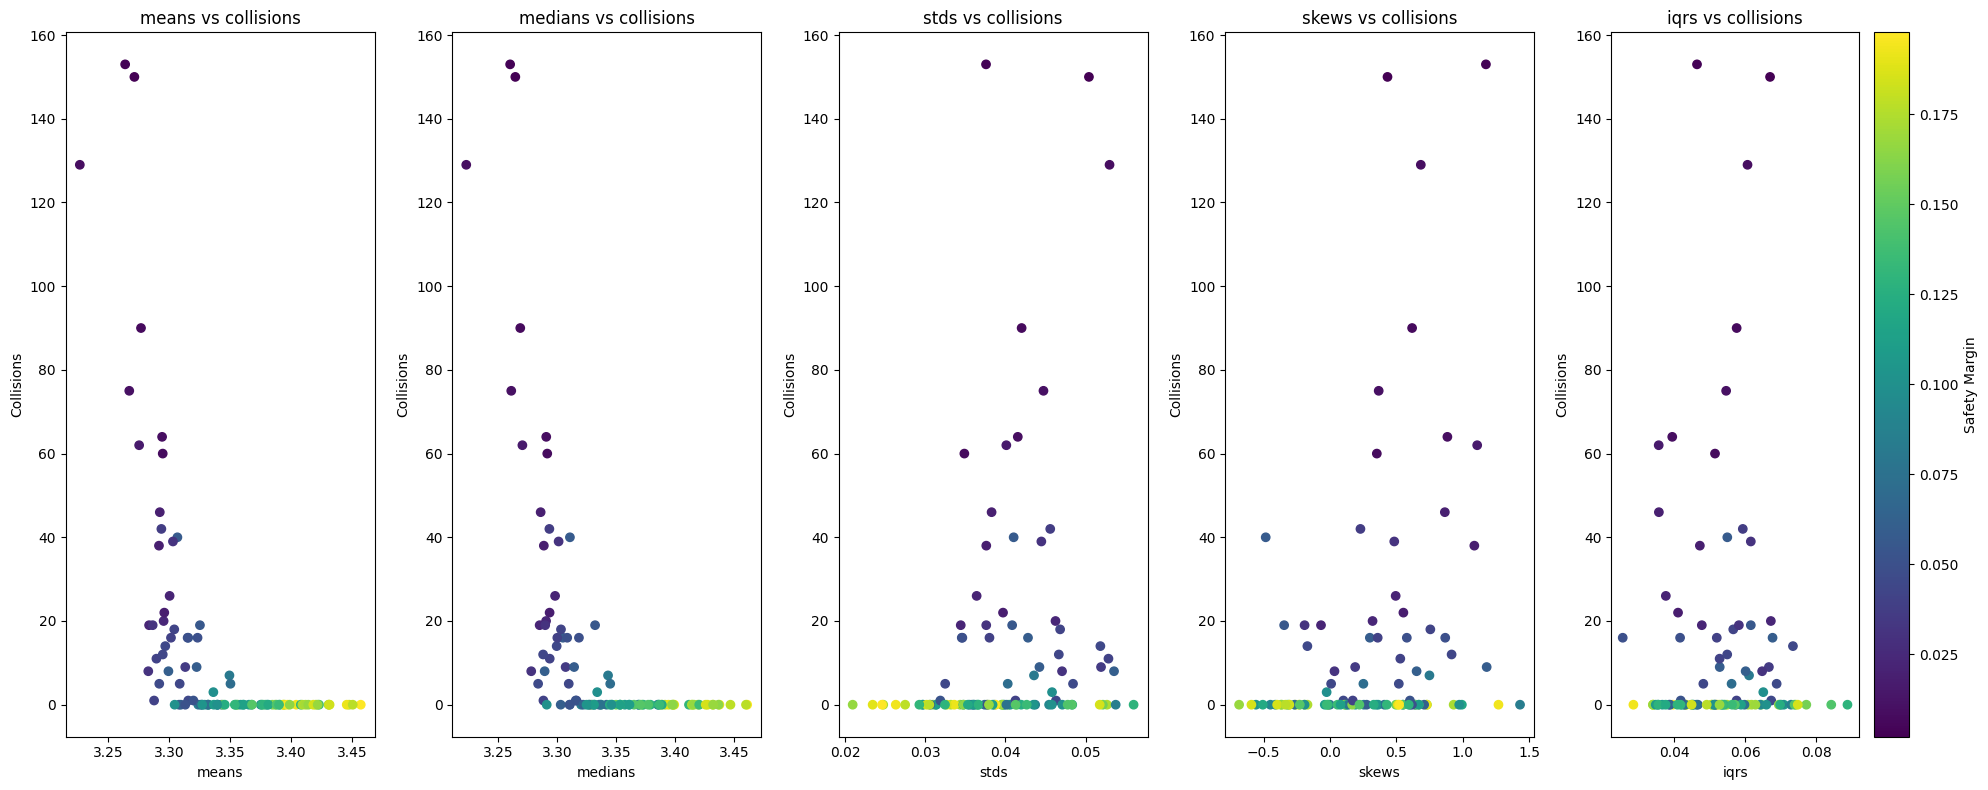

In [8]:
from scipy.stats import pearsonr,spearmanr, shapiro, skew, iqr

means=[]
medians=[]
stds=[]
skews=[]
iqrs=[]

for j in range(simulations):
    timeserie=dfORCA["persistentEntropy"].values[j]
    means.append(timeserie.mean())
    medians.append(np.median(timeserie))
    stds.append(timeserie.std())
    skews.append(skew(timeserie))
    iqrs.append(iqr(timeserie))

collisions= dfORCA["collisions"].values

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes = axes.flatten()

i=0
for x in [means,medians,stds,skews,iqrs]:
    feature2_name = [name for name in globals() if globals()[name] is x][0]
    print(f"-- Correlation between collisions y {feature2_name}")
    fu.show_correlation(collisions,x)
    plt.sca(axes[i])
    plt.scatter(x,collisions, c = dfORCA["safety_margin"].values)
    if i == 4:
        plt.colorbar(label='Safety Margin') 
    plt.title(f"{feature2_name} vs collisions")
    plt.xlabel(f"{feature2_name}")
    plt.ylabel('Collisions')
    i+=1

plt.tight_layout()
plt.savefig(f'Images/CrossDiscriminantEntropy_Collisions_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize persistent entropy time series with collisions vs no collisions

10it [00:00, 1018.41it/s]


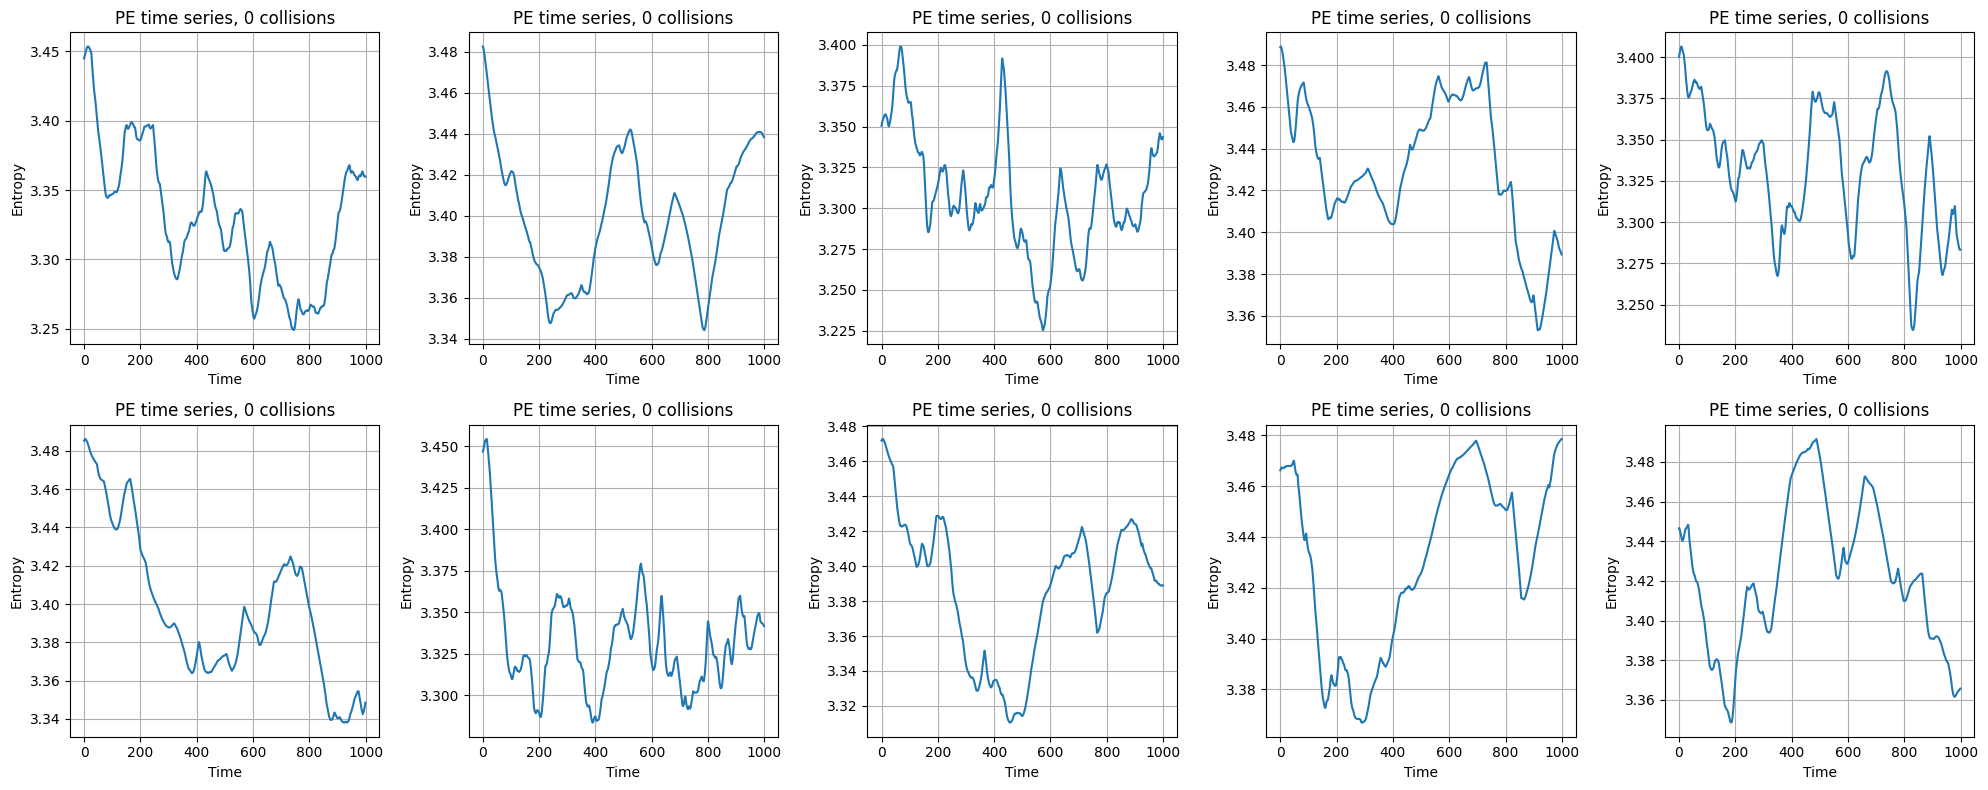

In [9]:
indexes_less_collisions=np.argsort(dfORCA["collisions"].values)[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_less_collisions)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    plt.title(f'PE time series, {dfORCA["collisions"].values[index]} collisions')
plt.tight_layout()
plt.savefig(f'Images/EntropyNoCollisionsTimeSeries{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

10it [00:00, 995.37it/s]


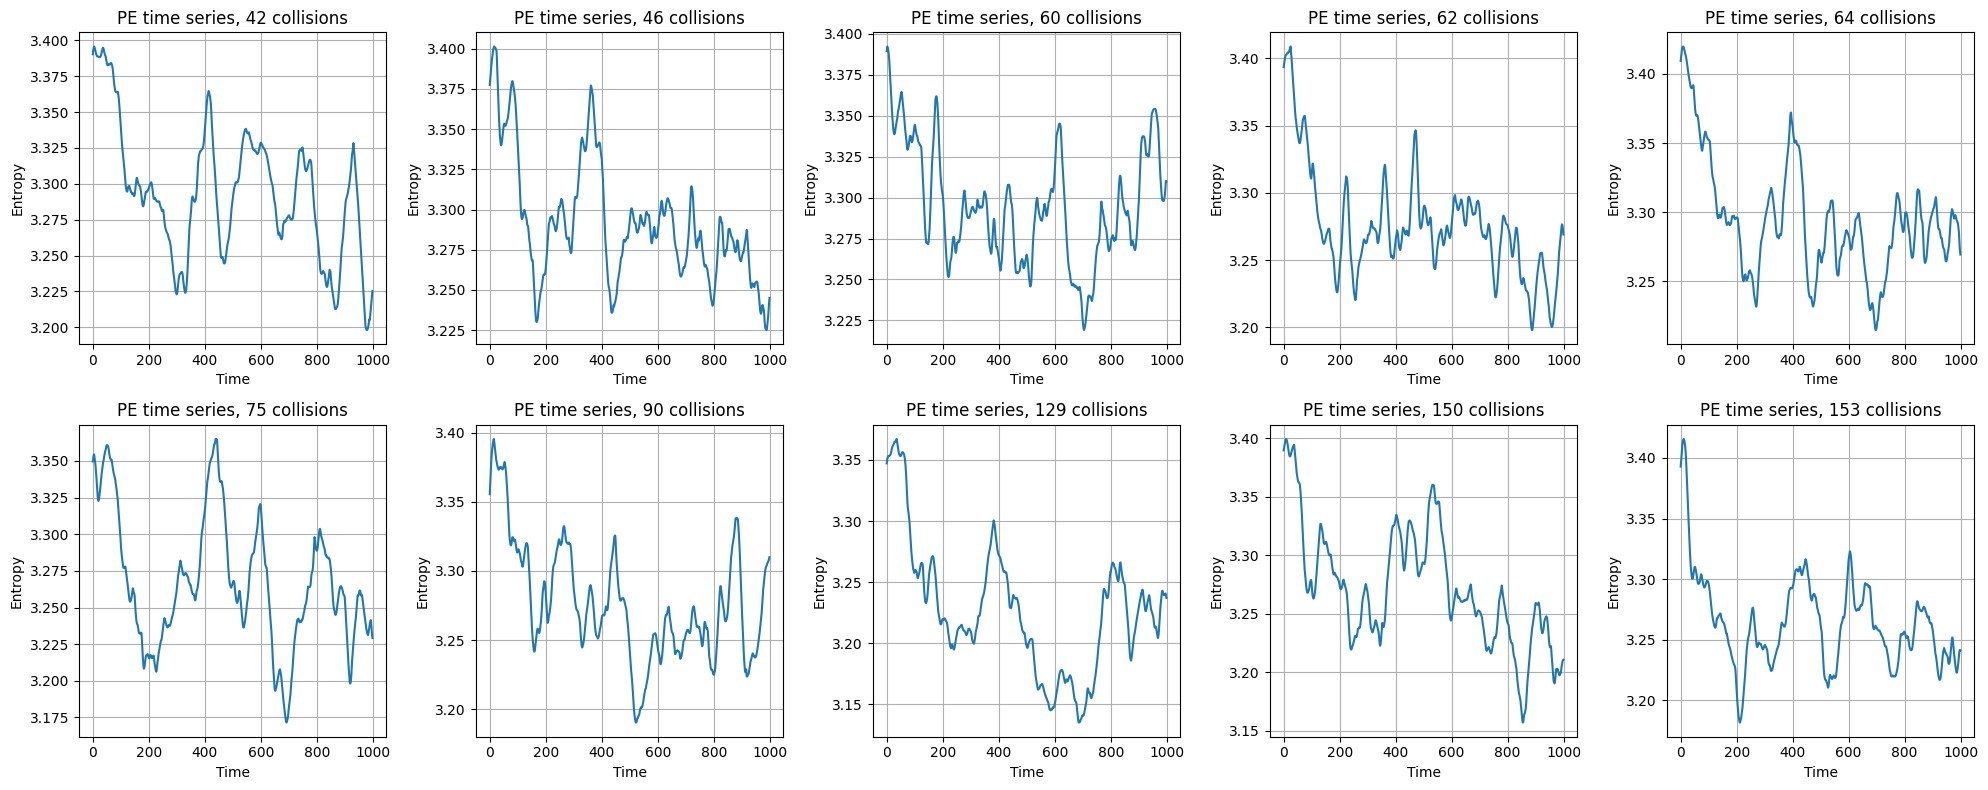

In [10]:
indexes_more_collisions=np.argsort(dfORCA["collisions"].values)[-10:]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_more_collisions)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    plt.title(f'PE time series, {dfORCA["collisions"].values[index]} collisions')
plt.tight_layout()
plt.savefig(f'Images/EntropyCollisionsTimeSeries{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

## Relation between Efficacy and Persistent entropy time series

The efficacy is given for each robot in each time step, so for a simulation of 1000 time step and 40 robots is an array of shape (1000,40). Navground consider the mean of these array for know the efficacy of an specific simulation. The efficacy: the projection of the current velocity on the ideal velocity (ignoring obstacles) towards the target. A value of 1.0 denotes ideal efficacy, value of 0.0 that the agent is stuck.

-- Correlation between efficacy y means
Pearson's correlation coefficient: -0.8819589220531199
P-value: 8.791460577342136e-34
The correlation is statistically significant.
-- Correlation between efficacy y medians
Pearson's correlation coefficient: -0.8805066183515101
P-value: 1.5436674574279118e-33
The correlation is statistically significant.
-- Correlation between efficacy y stds
Pearson's correlation coefficient: 0.2525534096345649
P-value: 0.011244143386134421
The correlation is statistically significant.
-- Correlation between efficacy y skews
Pearson's correlation coefficient: 0.4412185776644291
P-value: 4.332631925832468e-06
The correlation is statistically significant.
-- Correlation between efficacy y iqrs
Pearson's correlation coefficient: -0.07723898547977545
P-value: 0.444973883264287
There is insufficient evidence to reject the null hypothesis of no correlation.


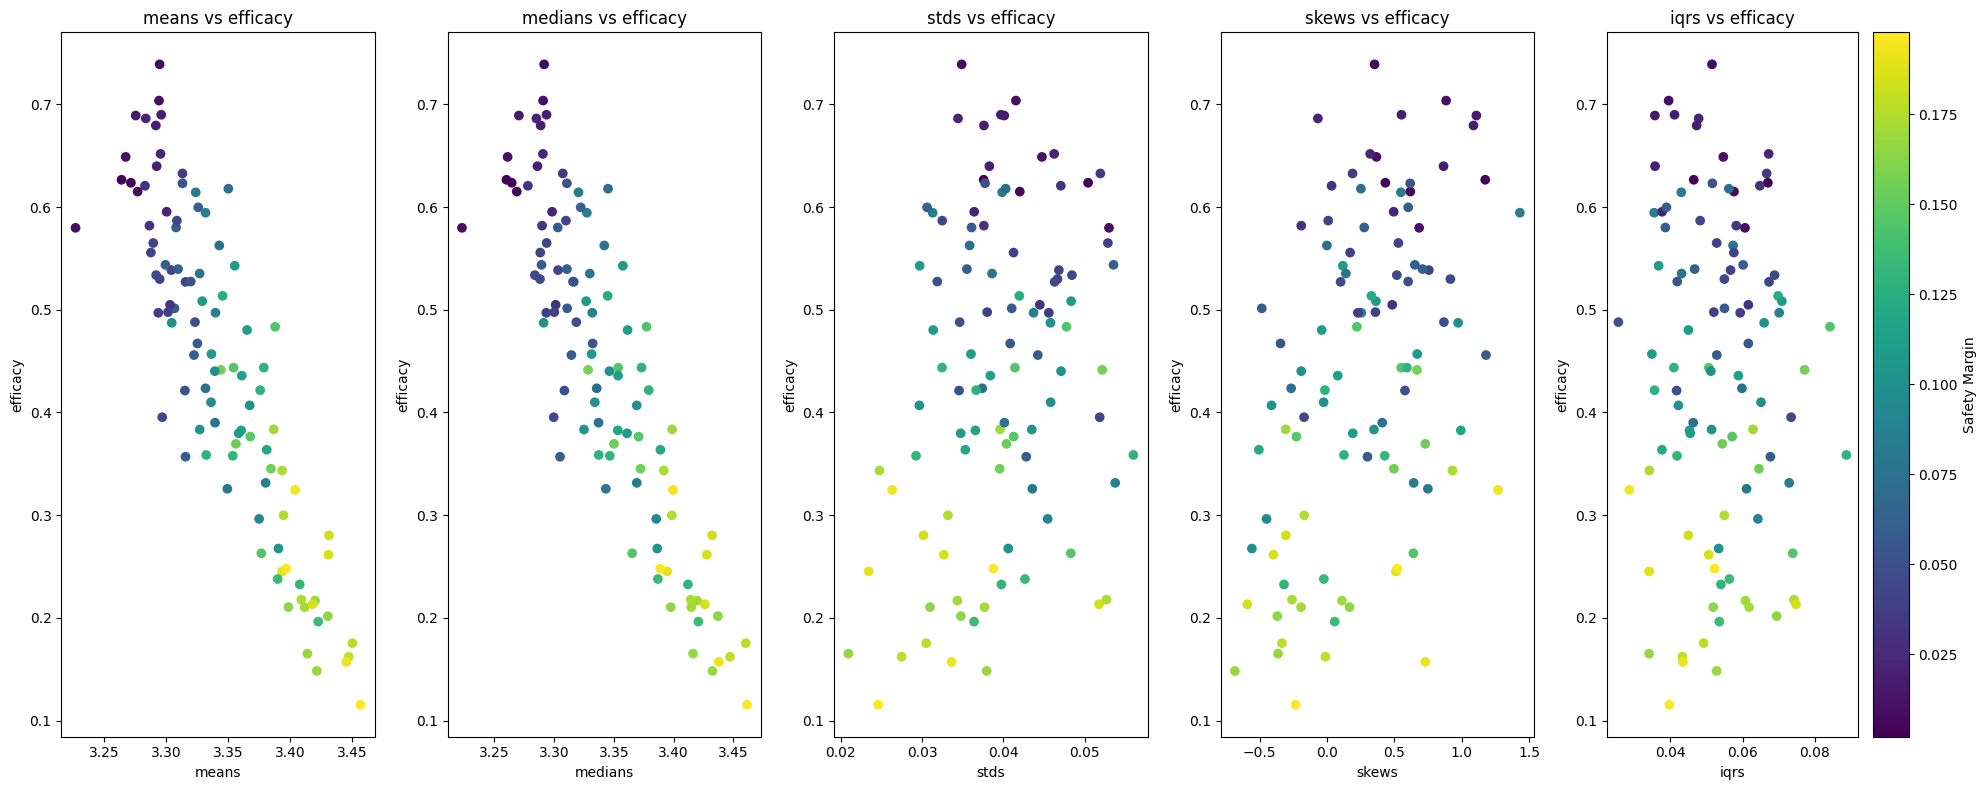

In [11]:
means=[]
medians=[]
stds=[]
skews=[]
iqrs=[]

for j in range(simulations):
    timeserie=dfORCA["persistentEntropy"].values[j]
    means.append(timeserie.mean())
    medians.append(np.median(timeserie))
    stds.append(timeserie.std())
    skews.append(skew(timeserie))
    iqrs.append(iqr(timeserie))

efficacy= dfORCA["efficacy"].values

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes = axes.flatten()

i=0
for x in [means,medians,stds,skews,iqrs]:
    feature2_name = [name for name in globals() if globals()[name] is x][0]
    print(f"-- Correlation between efficacy y {feature2_name}")
    fu.show_correlation(efficacy,x)
    plt.sca(axes[i])
    plt.scatter(x,efficacy, c = dfORCA["safety_margin"].values)
    if i == 4:
        plt.colorbar(label='Safety Margin') 
    plt.title(f"{feature2_name} vs efficacy")
    plt.xlabel(f"{feature2_name}")
    plt.ylabel('efficacy')
    i+=1

plt.tight_layout()
plt.savefig(f'Images/CrossDiscriminantEntropy_efficacy_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

10it [00:00, 1098.36it/s]


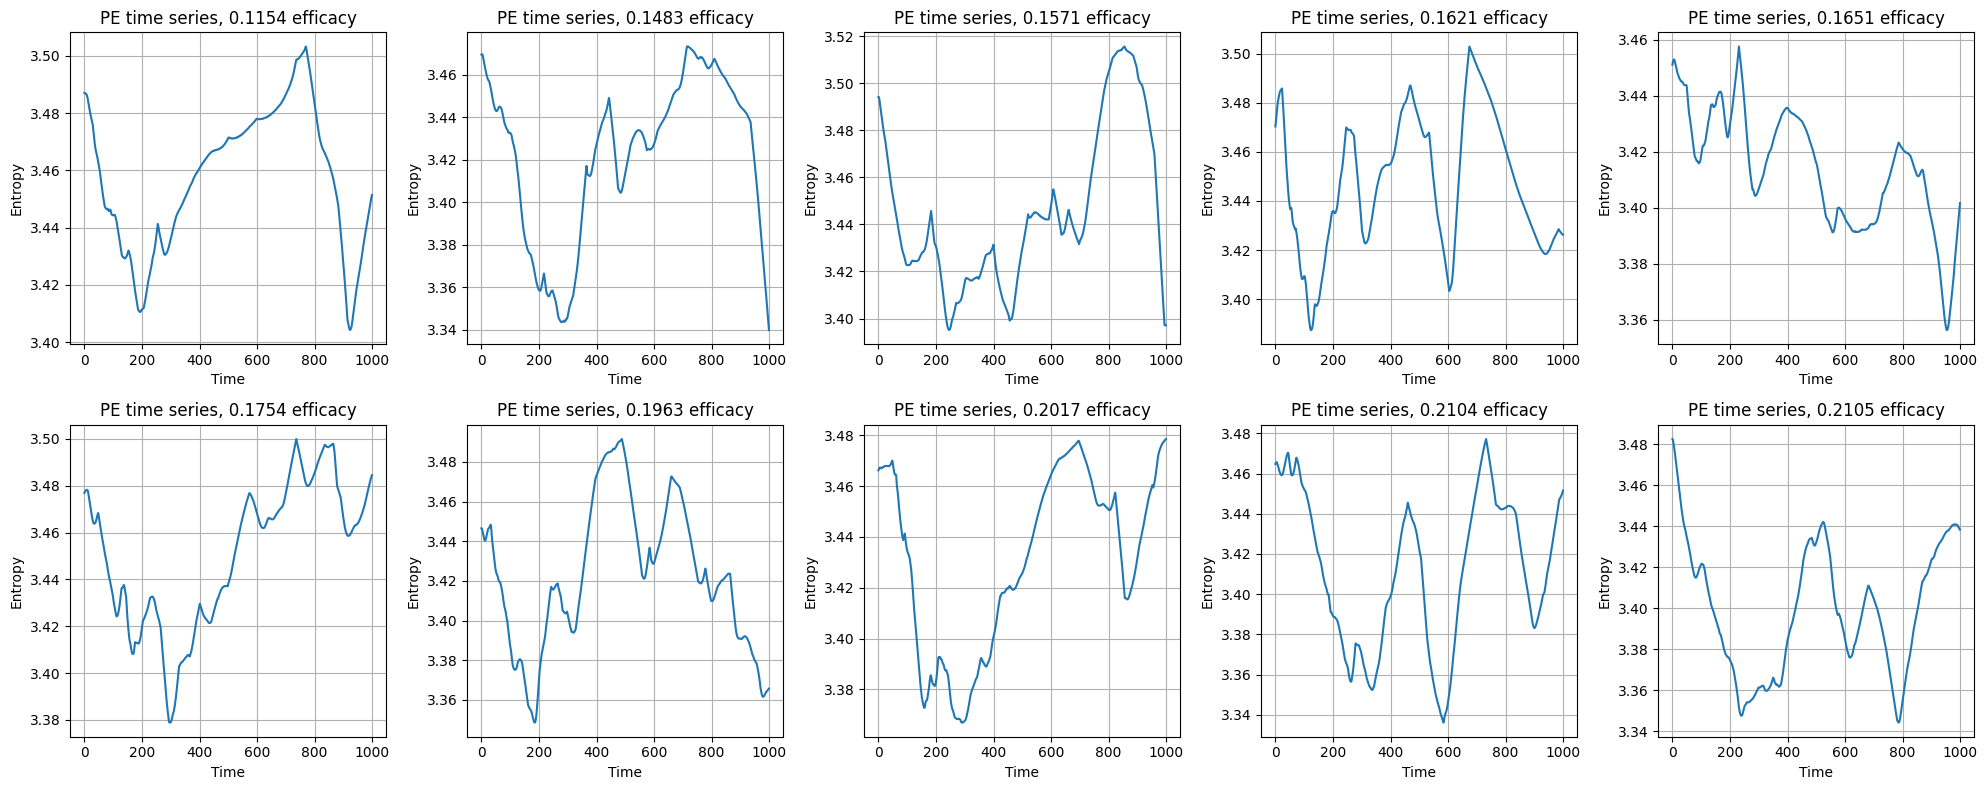

In [12]:
indexes_less_efficacys=np.argsort(dfORCA["efficacy"].values)[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_less_efficacys)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    efficacy = str(np.round(dfORCA["efficacy"].values[index],4))
    plt.title(f'PE time series, {efficacy} efficacy')
plt.tight_layout()
plt.savefig(f'Images/EntropyLessEfficacysTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

10it [00:00, 943.01it/s]


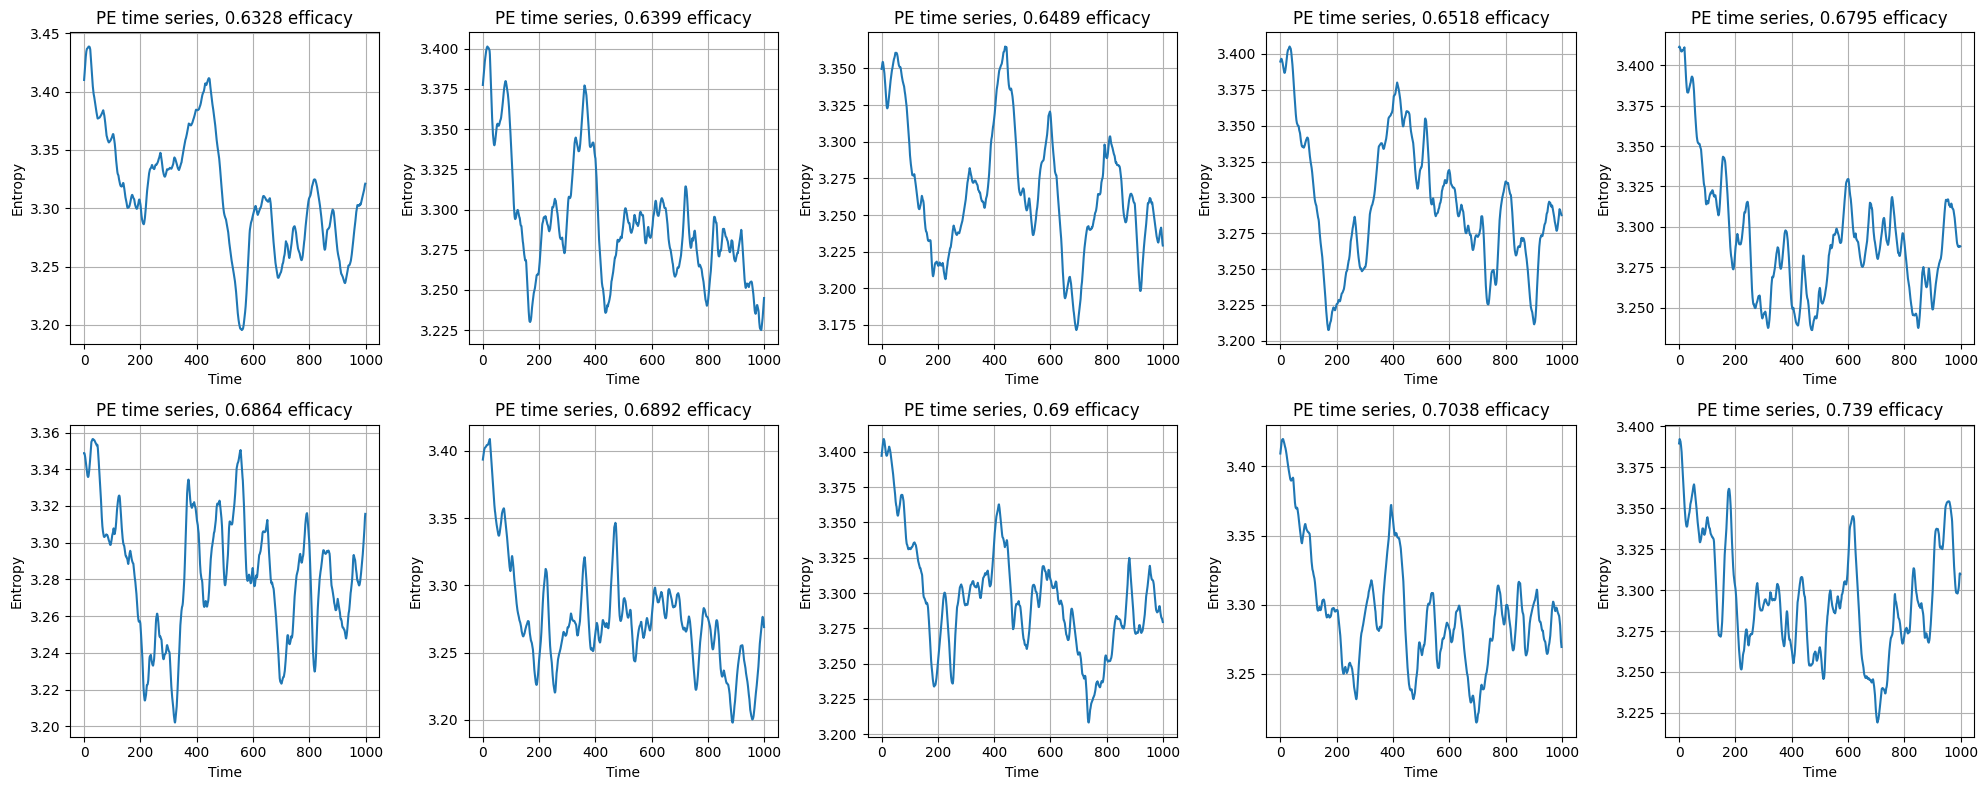

In [13]:
indexes_more_efficacys=np.argsort(dfORCA["efficacy"].values)[-10:]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_more_efficacys)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    efficacy = str(np.round(dfORCA["efficacy"].values[index],4))
    plt.title(f'PE time series, {efficacy} efficacy')
plt.tight_layout()
plt.savefig(f'Images/EntropyMoreEfficacysTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

## Neural network example

In [15]:
X = []
for i in dfORCA["persistentEntropy"]:
    X.append(i)
X = np.array(X)
y = np.array(dfORCA['safe'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input((X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3542 - loss: 1.3395 - val_accuracy: 0.8750 - val_loss: 0.3785
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4896 - loss: 0.9074 - val_accuracy: 0.1250 - val_loss: 1.2584
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3854 - loss: 0.8903 - val_accuracy: 0.8750 - val_loss: 0.4313
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6042 - loss: 0.7519 - val_accuracy: 0.8750 - val_loss: 0.3921
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - loss: 0.7183 - val_accuracy: 0.1250 - val_loss: 0.7158
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3750 - loss: 0.7139 - val_accuracy: 0.1250 - val_loss: 0.8167
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4167 - loss: 0.7284 - val_accuracy: 0.8750 - val_loss: 0.4582
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6146 - loss: 0.6991 - val_accuracy: 0.8750 - v

In [16]:
X.shape

(100, 1000)

In [13]:
y_test

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [14]:
model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.36999366],
       [0.37269762],
       [0.372987  ],
       [0.36518964],
       [0.3662911 ],
       [0.37008545],
       [0.37276635],
       [0.36916164],
       [0.36727533],
       [0.37098733],
       [0.3723745 ],
       [0.3694191 ],
       [0.37092936],
       [0.37126455],
       [0.37131277],
       [0.3675442 ],
       [0.36862144],
       [0.37018397],
       [0.3700319 ],
       [0.36991483]], dtype=float32)